source:

https://medium.com/wwblog/implement-the-on-balance-volume-obv-indicator-in-python-10ac889efe72

https://github.com/Magnifique-d/stock-trading-strategy/blob/main/On-Balance-Volume%20(OBV)/Stock_Trading_Strategy_(On_Balance_Volume).ipynb



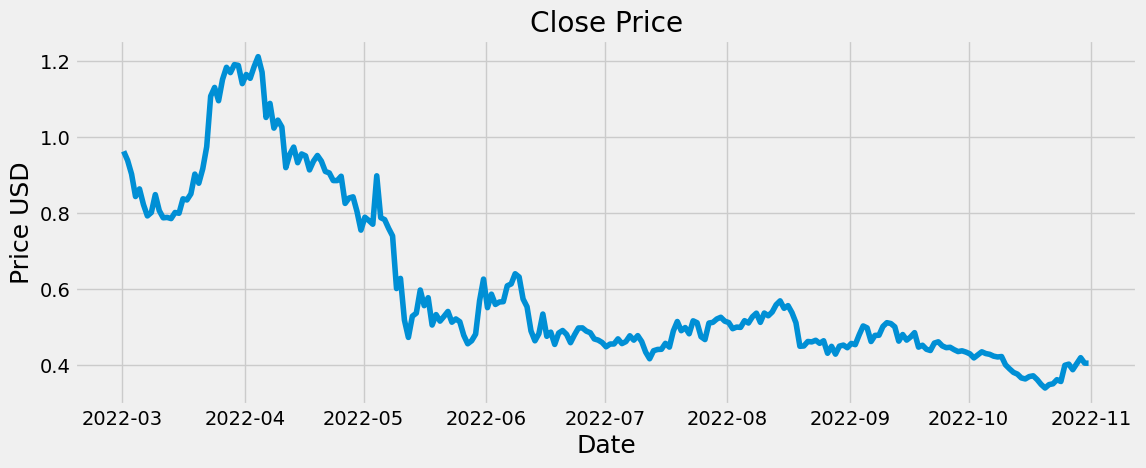

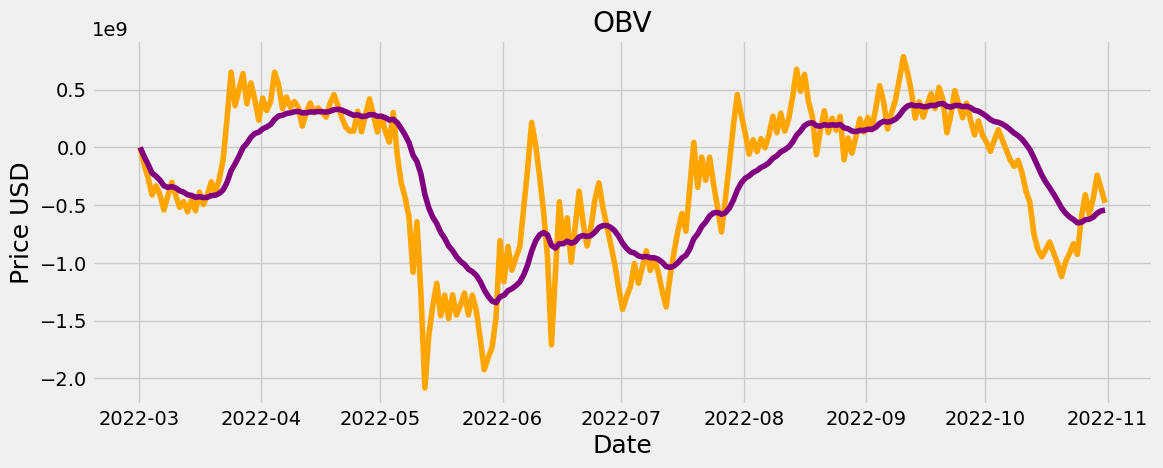

                         datetime    open    high     low   close  \
2022-03-01 08:00:00  1.646093e+12  0.9620  1.0110  0.9390  0.9630   
2022-03-02 08:00:00  1.646179e+12  0.9640  0.9770  0.9270  0.9390   
2022-03-03 08:00:00  1.646266e+12  0.9380  0.9460  0.8830  0.9030   
2022-03-04 08:00:00  1.646352e+12  0.9020  0.9030  0.8260  0.8440   
2022-03-05 08:00:00  1.646438e+12  0.8440  0.8830  0.8180  0.8640   
...                           ...     ...     ...     ...     ...   
2022-10-27 08:00:00  1.666829e+12  0.4030  0.4194  0.3861  0.3884   
2022-10-28 08:00:00  1.666915e+12  0.3884  0.4115  0.3777  0.4044   
2022-10-29 08:00:00  1.667002e+12  0.4044  0.4400  0.4008  0.4200   
2022-10-30 08:00:00  1.667088e+12  0.4201  0.4216  0.3981  0.4056   
2022-10-31 08:00:00  1.667174e+12  0.4057  0.4163  0.3975  0.4055   

                          volume    close_time           qav  num_trades  \
2022-03-01 08:00:00  234764266.6  1.646179e+12  2.275525e+08    333114.0   
2022-03-02 08:00:00

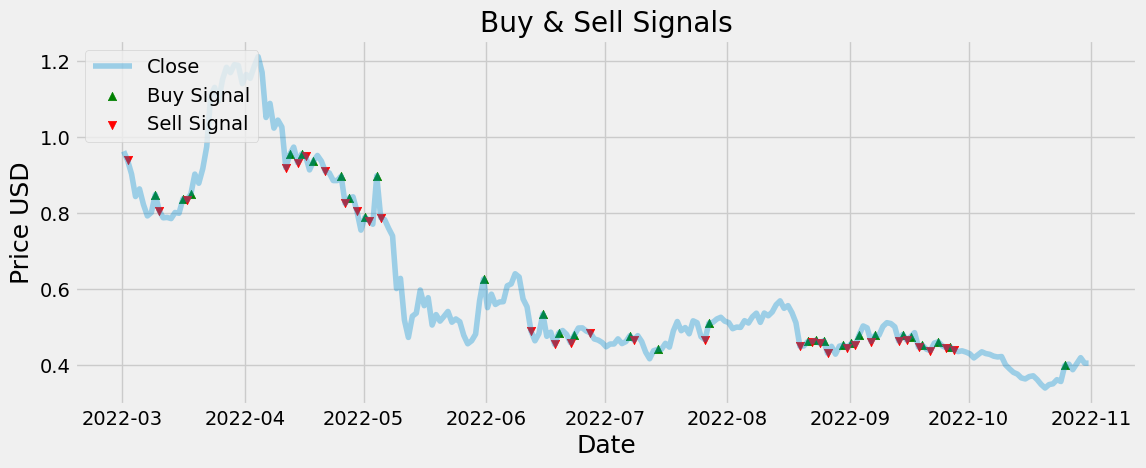

2022-03-01 08:00:00    0.000000e+00
2022-03-02 08:00:00   -1.494919e+08
2022-03-03 08:00:00   -2.642646e+08
2022-03-04 08:00:00   -4.112804e+08
2022-03-05 08:00:00   -3.325408e+08
                           ...     
2022-10-27 08:00:00   -5.806423e+08
2022-10-28 08:00:00   -4.414147e+08
2022-10-29 08:00:00   -2.405023e+08
2022-10-30 08:00:00   -3.576253e+08
2022-10-31 08:00:00   -4.802845e+08
Name: OBV, Length: 245, dtype: float64 2022-03-01 08:00:00    1.646093e+12
2022-03-02 08:00:00    1.646179e+12
2022-03-03 08:00:00    1.646266e+12
2022-03-04 08:00:00    1.646352e+12
2022-03-05 08:00:00    1.646438e+12
                           ...     
2022-10-27 08:00:00    1.666829e+12
2022-10-28 08:00:00    1.666915e+12
2022-10-29 08:00:00    1.667002e+12
2022-10-30 08:00:00    1.667088e+12
2022-10-31 08:00:00    1.667174e+12
Name: datetime, Length: 245, dtype: float64


In [12]:
import pandas as pd
import pandas_ta as ta

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import numpy as np
import requests
import matplotlib.pyplot as plt
from math import floor
from termcolor import colored as cl

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

from binance.client import Client
import datetime as dt
import json

url = 'https://api.binance.com/api/v3/klines'
symbol = 'ADAUSDT'
interval = '1d'
start = str(int(dt.datetime(2022,3,1).timestamp()*1000))
end = str(int(dt.datetime(2022,11,1).timestamp()*1000))
par = {'symbol': symbol, 'interval': interval, 'startTime': start, 'endTime': end}
data = pd.DataFrame(json.loads(requests.get(url, params= par).text))
#format columns name
data.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume','close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore']
data.index = [dt.datetime.fromtimestamp(x/1000.0) for x in data.datetime]
data=data.astype(float)

df = data

#Visually show the stock price
plt.figure(figsize=(12.2, 4.5))
plt.plot(df['close'], label = 'close')
plt.title('Close Price')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Price USD', fontsize = 18)
plt.show()

#Calculate the On Balance Volume (OBV)
OBV = []
OBV.append(0)

#Loop through the data set (close price) from the second row (index 1) to the end of the data set
for i in range(1, len(df.close)):
    if df.close[i] > df.close[i-1]:
        OBV.append(OBV[-1] + df.volume[i])
    elif df.close[i] < df.close[i-1]:
        OBV.append(OBV[-1] - df.volume[i])
    else:
        OBV.append(OBV[-1])

#Store the OBV and OBV Expontential Moving Average (EMA) into new columns
df['OBV'] = OBV
df['OBV_EMA'] = df['OBV'].ewm(span=20).mean()
#Show the data
df

#Create and plot the graph
plt.figure(figsize=(12.2, 4.5))
plt.plot(df['OBV'], label = 'OBV', color = 'orange')
plt.plot(df['OBV_EMA'], label = 'OBV_EMA', color = 'purple')
plt.title('OBV')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Price USD', fontsize = 18)
plt.show()

#Create a function to signal when to buy and sell the stock
# If OBV > OBV_EMA Then Buy
# If OBV < OBV_EMA Then Sell
# Else Do Nothing
def buy_sell(signal, col1, col2):
    signPriceBuy = []
    signPriceSell = []
    flag = -1
    #Loop through the length of the data set
    for i in range(0, len(signal)):
        #If OBV > OBV_EMA Then Buy --> col1 => 'OBV' and col2 => 'OBV_EMA'
        if signal[col1][i] > signal[col2][i] and flag != 1:
            signPriceBuy.append(signal['close'][i])
            signPriceSell.append(np.nan)
            flag = 1
        # If OBV < OBV_EMA Then Sell
        elif signal[col1][i] < signal[col2][i] and flag != 0:
            signPriceSell.append(signal['close'][i])
            signPriceBuy.append(np.nan)
            flag = 0
        else:
            signPriceSell.append(np.nan)
            signPriceBuy.append(np.nan)
    
    return (signPriceBuy, signPriceSell)

#Create buy and sell columns
x = buy_sell(df, 'OBV', 'OBV_EMA')


df['Buy_Signal_Price'] =  x[0]
df['Sell_Signal_Price'] = x[1]
#Show the data set
print(df)
   
#Plot the buy and sell prices
plt.figure(figsize=(12.2, 4.5))
plt.plot(df['close'], label = 'Close', alpha = 0.35)
plt.scatter(df.index, df['Buy_Signal_Price'], label = 'Buy Signal', marker = '^', alpha = 1, color = 'green')
plt.scatter(df.index, df['Sell_Signal_Price'], label = 'Sell Signal', marker = 'v', alpha = 1, color = 'red')
plt.title('Buy & Sell Signals')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Price USD', fontsize = 18)
plt.legend(loc='upper left')
plt.show()

print(df['OBV'], df['Buy_Signal_Price'],df['Sell_Signal_Price'])

In [13]:
data = df


# Create Figure
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_width=[0.25, 0.75])
# Inspect Result
print(fig)


fig.add_trace(go.Candlestick(
    x=data.index,
    open=data['open'],
    high=data['high'],
    low=data['low'],
    close=data['close'],
    increasing_line_color='#ff9900',
    decreasing_line_color='black',
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=data.index,
    y=data['OBV'],
    line=dict(color='#ff9900', width=2),
    showlegend=False,
    ), row=2, col=1
)

# Add upper/lower bounds
fig.update_yaxes(range=[-10, 110], row=2, col=1)
fig.add_hline(y=0, col=1, row=2, line_color="#666", line_width=2)
fig.add_hline(y=100, col=1, row=2, line_color="#666", line_width=2)
# Add overbought/oversold
fig.add_hline(y=30, col=1, row=2, line_color='#336699', line_width=2, line_dash='dash')
fig.add_hline(y=70, col=1, row=2, line_color='#336699', line_width=2, line_dash='dash')
# Customize font, colors, hide range slider
layout = go.Layout(
    plot_bgcolor='#efefef',
    # Font Families
    font_family='Monospace',
    font_color='#000000',
    font_size=20,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        )
    )
)

# for index, row in data.iterrows():
#         line_colour = 'orange' if (row['RSI_14_A_50'] == 1 and row['RSI_14_B_55'] == 0) else 'blue'
#         fig.add_vline(x=row.name, line_width=3, line_dash="dash", line_color=line_colour)

# update and display
fig.update_layout(layout)
fig.show()


Figure({
    'data': [],
    'layout': {'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'matches': 'x2', 'showticklabels': False},
               'xaxis2': {'anchor': 'y2', 'domain': [0.0, 1.0]},
               'yaxis': {'anchor': 'x', 'domain': [0.3625, 1.0]},
               'yaxis2': {'anchor': 'x2', 'domain': [0.0, 0.2125]}}
})
